In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61406 sha256=446c51cc3d6879ac62ecbf9f67f0551cb33aa21b425283cf9aa0311f128cfa89
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31530 sha256=e10ba09294651008afe5f09bd8b76939206c5d1c1f7153c73b0a0c6a8afe2303
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt201/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 187.2 MB/s eta 0:00:00


In [ ]:
import torch
from pytorch3d.io import load_obj, save_obj, load_objs_as_meshes
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    SoftPhongShader,
    MeshRasterizer,
    TexturesUV,
    TexturesAtlas
)
from torchvision.utils import make_grid

import numpy as np

from tqdm.notebook import tqdm

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['savefig.dpi']=80
# mpl.rcParams['figure.dpi']=80

if torch.cuda.is_available():
  device=torch.device("cuda:0")
else:
  device=torch.device('cpu')
  print('cannot find gpu')



In [ ]:
!pwd

/content


In [ ]:
!ls

drive  sample_data


In [ ]:
import os
os.chdir('drive/MyDrive/Colab Notebooks')

In [ ]:
!ls

data  deform_form.ipynb  rendering_texture_obj.ipynb


In [ ]:
!ls

data  deform_form.ipynb  rendering_texture_obj.ipynb


In [ ]:
DATA_DIR= "./data"
trg_obj=os.path.join(DATA_DIR, "cow_mesh/cow.obj")

verts,faces,aux=load_obj(trg_obj, create_texture_atlas=False,)

faces_idx=faces.verts_idx.to(device)
verts=verts.to(device)

#nromailization

center= verts.mean(0)
verts=verts-center
# print(verts.abs().max(0))

scale=max(verts.abs().max(0)[0])
verts=verts/scale

trg_mesh=Meshes(verts=[verts], faces=[faces_idx])

src_mesh=ico_sphere(4,device)


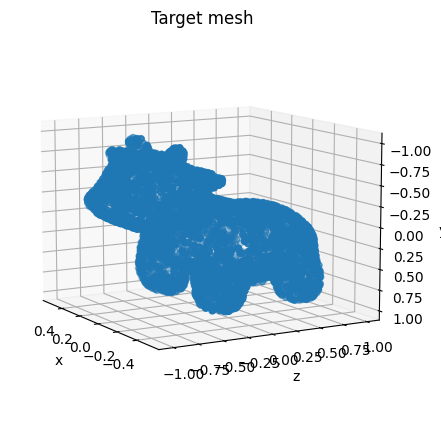

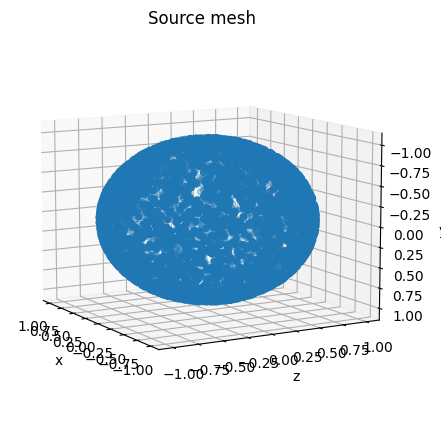

In [ ]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    # print(points.shape)
    point_cloud=points.clone().squeeze(0)

    x,y,z=point_cloud.detach().cpu().unbind(1)



    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()



%matplotlib inline
plot_pointcloud(trg_mesh, "Target mesh")
plot_pointcloud(src_mesh, "Source mesh")

In [ ]:
#the shape of the deform parameters is equal to the total number of vertices in src_mesh

deform_verts=torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)



optimizer=torch.optim.SGD([deform_verts], lr=1, momentum=0.9)


Niter=10000
w_chamfer=1
w_edge=1
w_normal=0.1
w_lap=1

plot_period=250

chamfer_loss=[]
edge_loss=[]
normal_loss=[]
lap_loss=[]

loop=tqdm(range(Niter))
new_src_mesh=src_mesh.offset_verts(deform_verts)

for i in loop:
  optimizer.zero_grad()
  new_src_mesh=src_mesh.offset_verts(deform_verts)
  sample_trg = sample_points_from_meshes(trg_mesh, 5000)
  sample_src = sample_points_from_meshes(new_src_mesh, 5000)
  # We compare the two sets of pointclouds by computing (a) the chamfer loss
  loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

  # and (b) the edge length of the predicted mesh
  loss_edge = mesh_edge_loss(new_src_mesh)

  # mesh normal consistency
  loss_normal = mesh_normal_consistency(new_src_mesh)

  # mesh laplacian smoothing
  loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

  # Weighted sum of the losses
  loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_lap

  # Print the losses
  loop.set_description('total_loss = %.6f' % loss)

  # Save the losses for plotting
  chamfer_loss.append(float(loss_chamfer.detach().cpu()))
  edge_loss.append(float(loss_edge.detach().cpu()))
  normal_loss.append(float(loss_normal.detach().cpu()))
  lap_loss.append(float(loss_laplacian.detach().cpu()))

  # Plot mesh
  if i % plot_period == 0:
      plot_pointcloud(new_src_mesh, title="iter: %d" % i)

  # Optimization step
  loss.backward()
  optimizer.step()


Output hidden; open in https://colab.research.google.com to view.

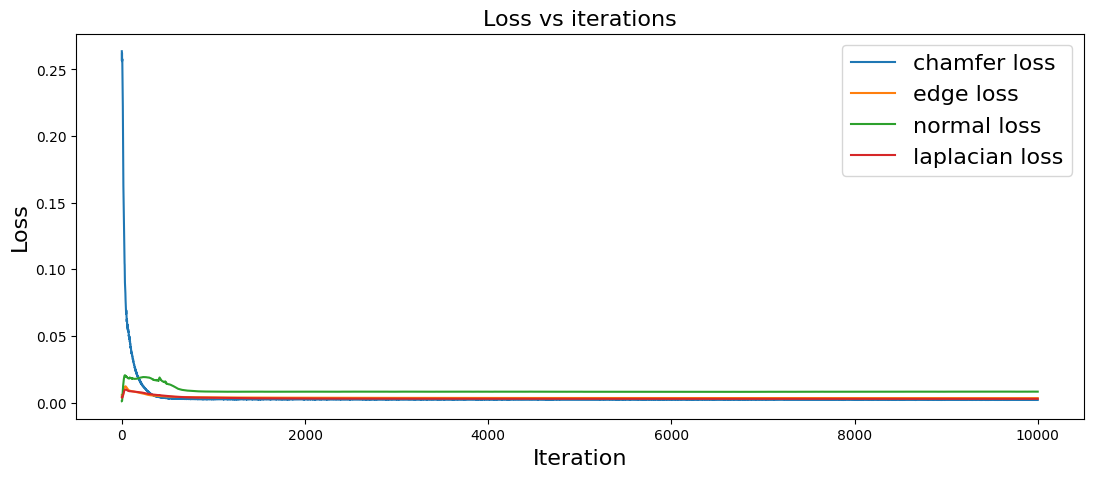

In [ ]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_loss, label="chamfer loss")
ax.plot(edge_loss, label="edge loss")
ax.plot(normal_loss, label="normal loss")
ax.plot(lap_loss, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

In [ ]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = 'final_model.obj'
save_obj(final_obj, final_verts, final_faces)